In [23]:
import pandas as pd
import numpy as np

from IPython.display import display

# Klasyfikacja probabilistyczna

Autor sekcji: {ref}`authors:filip-wojcik`.


W poprzednich rozdziałach zagadnienie klasyfikacji zostało przedstawione w nieco uproszczony sposób, zakładając, że wynikiem działania modelu jest bezpośrednie przypisanie obserwacji do jednej z klas. W rzeczywistości większość modeli uczenia maszynowego zwraca prawdopodobieństwa przynależności do klas, a nie same przypisania. Domyślnie przyjmuje się poziom odcięcia (ang. *threshold*) równy 0.5, co oznacza, że jeżeli prawdopodobieństwo przynależności do danej klasy przekracza tę wartość, to model przypisuje obserwację do tej klasy. Jednak w praktyce próg ten może być dostosowywany w zależności od potrzeb konkretnej aplikacji.

Formalnie zapisujemy:

$$
\hat{y} = \begin{cases}
1 & \text{jeżeli } p(y=1 | x) > \text{threshold} \\
0 & \text{w przeciwnym przypadku}
\end{cases}
$$

dla klasyfikacji binarnej.

```{admonition} Wyjście z modelu w klasyfikacji probabilistycznej
:class: tip
W przypadku klasyfikacji probabilistycznej - model zwraca prawdopodobieństwa przynależności do klas, a nie same przypisania. Tym samym wynik działania modelu jest macierzą o wymiarach `N x K`, gdzie K = liczba klas, a N = liczba obserwacji. Jest zatem podobny w swoim kształcie do wyniku działania kodowania OHE.
```


## Metryki dla klasyfikacji probabilistycznej

Klasyfikacja probabilistyczna wprowadza dodatkowe możliwości oceny jakości modelu. Zamiast oceniać model na podstawie przypisanych klas, możemy skupić się na tym, jak dobrze model przewiduje prawdopodobieństwa przynależności do klas. Poniżej przedstawiamy kilka najważniejszych metryk oraz narzędzi używanych do oceny modeli probabilistycznych.

### Log-Loss (funkcja logarytmiczna straty) i Cross-Entropy (entropia krzyżowa)

*Log-loss* oraz *cross-entropy* to kluczowe metryki używane do oceny modeli probabilistycznych, zwłaszcza w przypadku klasyfikacji wieloklasowej. Metryki te mierzą, jak bardzo przewidywane prawdopodobieństwa odbiegają od rzeczywistych etykiet.

```{glossary}
Log-loss

    Dla klasyfikacji binarnej *log-loss* jest definiowany jako {cite:ps}`hastie2009elements`:

    $$
    \text{Log-loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ \textcolor{red}{y_i \log(p_i)} + \textcolor{blue}{ (1 - y_i) \log(1 - p_i)} \right]
    $$

    gdzie:
    - $ y_i $ to rzeczywista etykieta (0 lub 1),
    - $ p_i $ to przewidywane prawdopodobieństwo dla klasy 1,
    - $ N $ to liczba próbek.
```

Ciekawą własnością tego równania jest fakt, że w zależności od klasy docelowej, "aktywna" jest tylko jedna jeggo część, a druga się zeruje.
1. W przypadku, gdy $y=1$, wówczas zaznaczona na niebiesko część równania ulega wyzerowaniu, bo $y_i = 1$, a więc $1 - y_i = 0$. A zatem rozpatrujemy tylko część "czerwoną" - iloczyn przewidzianego prawdopodobieństwa i rzeczywistej etykiety.
2. Analogicznie, gdy $y=0$, to zaznaczona na czerwono część równania ulega wyzerowaniu, bo $y_i = 0$, a więc $1 - y_i = 1$. A zatem rozpatrujemy tylko część "niebieską" - iloczyn przewidzianego prawdopodobieństwa i rzeczywistej etykiety.

```{glossary}
Entropia krzyżowa / ang. *cross entropy*
    Dla klasyfikacji wieloklasowej, *cross-entropy* (która jest rozszerzeniem *log-loss*) jest definiowana jako {cite:ps}`hastie2009elements`:


    $$
    \text{Cross-Entropy} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(p_{i,c})
    $$

    gdzie:
    - $ C $ to liczba klas,
    - $ y_{i,c} $ to wskaźnik binarny czy próbka $ i $ należy do klasy $ c $ (1 lub 0),
    - $ p_{i,c} $ to przewidywane prawdopodobieństwo, że próbka $ i $ należy do klasy $ c $.
```

Przykład kodu w Pythonie obliczającego *log-loss* oraz *cross-entropy*:

In [24]:
from sklearn.metrics import log_loss
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from feature_engine.encoding import OrdinalEncoder
import numpy as np


iris = load_iris()
iris_data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_data["species"] = [iris.target_names[i] for i in iris.target]

# Kodowanie numeryczne klas - tym razem nie używamy OHE
ordinal_encoder = OrdinalEncoder(encoding_method='arbitrary', variables=['species'])
iris_encoded  = ordinal_encoder.fit_transform(iris_data)


# Podział na dane treningowe i testowe
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(iris_encoded.drop(columns=["species"]),
                                                    iris_encoded["species"],
                                                    test_size=0.2,
                                                    random_state=42)

# Trenowanie modelu logistycznej regresji
logreg_iris = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg_iris.fit(X_train_iris, y_train_iris)

# Przewidywanie prawdopodobieństw
y_prob_iris = logreg_iris.predict_proba(X_test_iris)

# Przykładowe prawdopodobieństwa dla pierwszych 3 obiektów
# Macierz N x 3. Drugi wymiar (=3) odpowiada ilości klas.
display(y_prob_iris[:3])

# Obliczanie log-loss (cross-entropy) dla wieloklasowej klasyfikacji
log_loss_value = log_loss(y_test_iris, y_prob_iris)
print(f'Log-Loss / Cross-Entropy: {log_loss_value:.4f}')

/home/filip/miniconda3/envs/dsbook/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


array([[3.80467719e-03, 8.27741160e-01, 1.68454163e-01],
       [9.46983711e-01, 5.30160908e-02, 1.98729666e-07],
       [8.86544005e-09, 1.54858232e-03, 9.98451409e-01]])

Log-Loss / Cross-Entropy: 0.1111


### **Krzywa ROC i AUC (Receiver Operating Characteristic i Pole pod Krzywą ROC)**

```{glossary}
Krzywa ROC 
    ang. **Receiver Operating Characteristic** jest wykresem, który pokazuje zależność pomiędzy czułością (ang. *True Positive Rate, TPR* lub *Recall*) a współczynnikiem fałszywie pozytywnych wyników (ang. *False Positive Rate, FPR*) przy różnych poziomach odcięcia (ang. *threshold*) prawdopodobieństwa. Pole pod krzywą ROC (ang. *Area Under the Curve, AUC*) jest miarą jakości modelu – im większe pole, tym lepszy model.

    Innymi słowy, krzywa ROC i AUC pomaga sprawdzić, czy na pewno domyślny próg 0.5 jest najlepszym wyborem dla modelu klasyfikacji probabilistycznej.
```

Wzory na *True Positive Rate* oraz *False Positive Rate*:

$$
\text{TPR} = \frac{TP}{TP + FN}
$$

$$
\text{FPR} = \frac{FP}{FP + TN}
$$

Przykład kodu w Pythonie generującego krzywą ROC i obliczającego AUC, dla binarnej klasyfikacji dla danych z Titanica.


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

titanic_cols_to_take = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'adult_male']

url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv"
titanic_data = pd.read_csv(url)

# Wstępne przygotowanie danych - wypełnienie wart. brakujących i kodowanie OHE
num_imputer = MeanMedianImputer(imputation_method='median')
cat_imputer = CategoricalImputer(imputation_method='missing', fill_value='missing')
titanic_ohe = OneHotEncoder(variables=['sex', 'embarked', 'class', 'adult_male'], ignore_format=True)
transformation_pipe = make_pipeline(num_imputer, cat_imputer, titanic_ohe)

X = titanic_data.drop(columns=["survived"])[titanic_cols_to_take]
y = titanic_data["survived"]

# Podział danych na treningowe i testowe
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_titanic = transformation_pipe.fit_transform(X_train_titanic)
X_test_titanic = transformation_pipe.transform(X_test_titanic)


ROC AUC: 0.7808


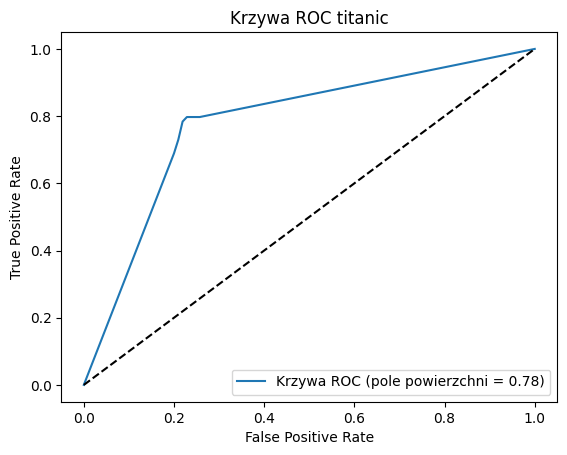

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Przygotowanie modelu
model_titanic = DecisionTreeClassifier(random_state=42)
model_titanic.fit(X_train_titanic, y_train_titanic)

# Predycke prawdopodobieństwa dla danych zw z katastrofą Titanica
yhat_titanic_proba = model_titanic.predict_proba(X_test_titanic)

# Obliczanie krzywej ROC
fpr, tpr, thresholds = roc_curve(y_test_titanic, yhat_titanic_proba[:, 1])

# Obliczanie AUC
auc = roc_auc_score(y_test_titanic, yhat_titanic_proba[:, 1])
print(f'ROC AUC: {auc:.4f}')

# Rysowanie krzywej ROC
plt.plot(fpr, tpr, label=f'Krzywa ROC (pole powierzchni = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Linia przerywana (losowy klasyfikator)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC titanic')
plt.legend(loc="lower right")
plt.show()


Jak widać w powyższym przykładzie - model wyszkolony dla danych związanych z katastrofą Titanica, zdecydowanie przewyższa wyniki losowego klasyfikatora.

### **Krzywa precision-recall i AUC (Precision-Recall Curve i Pole pod Krzywą Precision-Recall)**

Krzywa *precision-recall* jest alternatywą dla krzywej ROC, szczególnie przydatną w przypadku, gdy klasy są niezrównoważone.

Przykład kodu generującego tą krzywą dla danych zw. z katastrofą Titanica.


Precision-Recall AUC: 0.7771


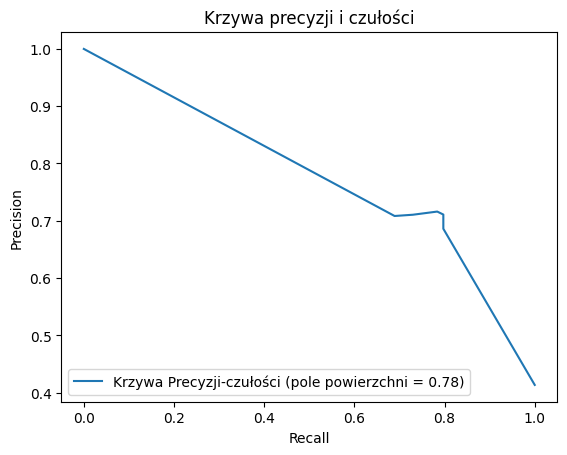

In [27]:
from sklearn.metrics import precision_recall_curve, auc

# Obliczanie krzywej precision-recall
precision, recall, thresholds = precision_recall_curve(y_test_titanic, yhat_titanic_proba[:, 1])

# Obliczanie AUC dla krzywej precision-recall
pr_auc = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc:.4f}')


plt.plot(recall, precision, label=f'Krzywa Precyzji-czułości (pole powierzchni = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Krzywa precyzji i czułości')
plt.legend(loc="lower left")
plt.show()

### Kalibracja Prawdopodobieństwa

Kalibracja prawdopodobieństwa jest procesem dostosowywania prognoz modelu, aby lepiej odpowiadały rzeczywistym prawdopodobieństwom. W ramach tego procesu, steruje się progiem odcięcia/przypisania, zilustrowanym powyżej. Może się okazać, że np. dla danego problemu dużo lepszym wyborem jest graniczny próg prawdopodobieństwa 0.3, a nie 0.5.

Jednym z najczęściej używanych narzędzi do kalibracji jest `CalibratedClassifierCV` w Scikit-learn, który można zastosować do każdego modelu klasyfikacyjnego.

To narzędzie wykorzystuje **walidację krzyżową** (ang. *cross-validation*) - którą poznamy bliżej w kolejnych rozdziałach - do wykonania dwóch działań **dla każdego z k podziałów (`train,test`):
1. Znalezienia optymalnych parametrów modelu;
2. Znalezienia optymalnego progu prawdopoobieństwa dla przypisania do klasy (czyli: $P(y_i = 1 \mid F_i )$ ), dla którego model osiąga najlepsze wyniki. Ten efekt osiąga się szkoląc meta-model, zwany `kalibratorem`, który mapuje "surowe" prawdopodobieństwo przypisania do klasy z modelu na nową wartość. Formalnie:

$$
F_i = \text{kalibrator}(\text{model}(\mathbf{x}_i; \theta))
$$
gdzie `model` to nasz oryginalny (nieskalibrowany) model uczenia maszynowego, a  $\theta$ to jego parametry.

Wielokrotnie dzieląc zbiór danych na treningowy i testowy, szkoląc klasyfikator oraz kalibrator, można uzyskać dużo lepsze osiągi. Biblioteka `sklearn` umożliwia w tym miejscu, dodatkowo wykonanie połączenia wielu modeli (ang. *model ensemble*) dla wzmocnienia tego efektu.

`CalibratedClassifierCV` może działać w dwóch trybach:
1. Klasyfikatora złożonego (ang. *ensemble*) - gdzie łączy wyniki z wielu modeli;
2. Klasyfikatora nieobciążonego (ang. *unbiased*) - gdzie występuje tylko jeden kalibrator - szkolony na wyniku predykcji dla podzbiorów testowych w walidacji krzyżowej (każdy punkt danych pojawia się tylko w jednym zbiorze testowym).

Dokładny przewodnik po działaniu i szczegółach implantacyjnych kalibratora prawdopodobieństwa, można znaleźć w [przewodniku sklearn](https://scikit-learn.org/stable/modules/calibration.html).


Przykład poniżej.

Log-loss score przed kalibracją: 7.2923
F1 przed kalibracją: 0.7200
ROC AUC przed kalibracją: 0.7808



Log-loss po kalibracji: 0.4892
F1 po kalibracji: 0.7286
ROC AUC po kalibracji: 0.8609


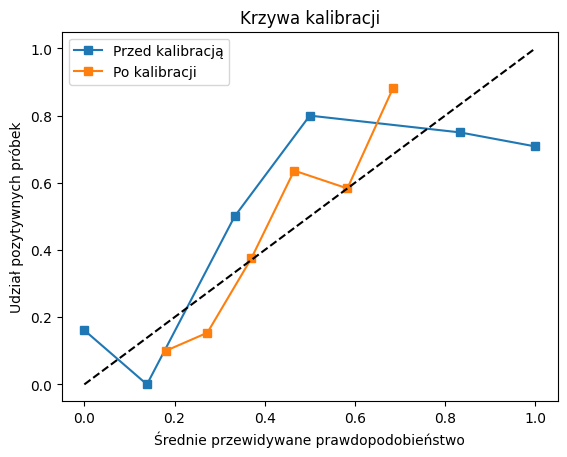

In [28]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import f1_score

# Kalibracja modelu z wykorzystaniem CalibratedClassifierCV.
calibrated_model = CalibratedClassifierCV(model_titanic, method='sigmoid', cv=5)
calibrated_model.fit(X_train_titanic, y_train_titanic)

# Przewidywanie prawdopodobieństw po kalibracji
yhat_prob_titanic_calibrated = calibrated_model.predict_proba(X_test_titanic)[:, 1]

# Przewidywanie przypisania klasy na podstawie skalibrowanego prawdopodobieństwa
yhat_titanic_calibrated = calibrated_model.predict(X_test_titanic)

# Obliczanie Log-loss oraz F1 przed i po kalibracji
log_loss_before = log_loss(y_test_titanic, yhat_titanic_proba)
f1_before = f1_score(y_test_titanic, yhat_titanic_proba[:, 1] > 0.5)
auc_before = roc_auc_score(y_test_titanic, yhat_titanic_proba[:, 1])

brier_after = log_loss(y_test_titanic, yhat_prob_titanic_calibrated)
f1_after = f1_score(y_test_titanic, yhat_titanic_calibrated)
auc_after = roc_auc_score(y_test_titanic, yhat_prob_titanic_calibrated)

print(f'Log-loss score przed kalibracją: {log_loss_before:.4f}')
print(f'F1 przed kalibracją: {f1_before:.4f}')
print(f'ROC AUC przed kalibracją: {auc_before:.4f}')
print("\n\n")
print(f'Log-loss po kalibracji: {brier_after:.4f}')
print(f'F1 po kalibracji: {f1_after:.4f}')
print(f'ROC AUC po kalibracji: {auc_after:.4f}')

# Rysowanie krzywej kalibracji
prob_true, prob_pred = calibration_curve(y_test_titanic, yhat_titanic_proba[:, 1], n_bins=10)
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_test_titanic, yhat_prob_titanic_calibrated, n_bins=10)

plt.plot(prob_pred, prob_true, 's-', label='Przed kalibracją')
plt.plot(prob_pred_calibrated, prob_true_calibrated, 's-', label='Po kalibracji')
plt.plot([0, 1], [0, 1], 'k--')  # Idealna kalibracja
plt.xlabel('Średnie przewidywane prawdopodobieństwo')
plt.ylabel('Udział pozytywnych próbek')
plt.title('Krzywa kalibracji')
plt.legend(loc="best")
plt.show()

W pokazanym przykładzie widzimy, że po kalibracji spadła wartość log-loss, oraz wzrósł współczynnik F1.